In [65]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import re
import random
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


### Read Data

In [41]:
df1 = pd.read_excel('data/DDS9_Data_Extract_with_labels.xlsx')
df2 = pd.read_excel('data/DDS10_Data_Extract_with_labels.xlsx')
df3 = pd.read_excel('data/DDS11_Data_Extract_with_labels.xlsx')

### Concatenated dataset for the common columns

In [42]:
df1cols = set(df1.columns)
df2cols = set(df2.columns)
df3cols = set(df3.columns)
common_cols = list(df1cols.intersection(df2cols).intersection(df3cols))
#print(len(common_cols))
merged_df = pd.concat([df1[common_cols], df2[common_cols], df3[common_cols]], ignore_index=True)
#merged_df

In [43]:
#print(df1.columns)

### Model 1: Relationship between household income and media/home entertainment equipment owned by a household

In [44]:
# Renaming column names for modeling
df1 = df1.rename(columns={"Q6 - Into which of the following categories does your total annual household income fall before taxes? Again, we promise to keep this, and all your answers, completely confidential.":"household_income",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Digital video recorder (DVR)":"DVR_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Flat panel television":"FlatTV_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Streaming media box or over-the-top box":"MediaBox_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Portable streaming thumb drive/fob":"Fob_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Blu-ray disc player/DVD player":"DVD_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Gaming console":"GamingCon_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Portable video game player":"PortableGame_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Computer network/router in your home for wireless computer/laptop usage":"Router_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Desktop computer":"Desktop_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop computer":"Laptop_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Laptop/tablet hybrid":"LapTabHybrid_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Tablet (nine inches and above)":"Tab9in_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Small tablet (between seven and nine inches)":"Tab7_9in_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Dedicated e-book reader":"EbookReader_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Smartphone (three to five inches)":"Smartphone3_5in_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Large smartphone (between five and seven inches)":"LargeSmartphone_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Basic mobile phone (not a smartphone)":"BasicMobile_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Smart watch":"Smartwatch_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Fitness band":"FitnessBand_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Smart glasses":"SmartGlasses_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-3D printer":"3DPrinter_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-None of the above":"None_owned",
                        "Q8 - Which of the following media or home entertainment equipment does your household own?-Don't Know":"DontKnow_owned"})
                
#df1.columns

In [45]:
# Setting up data for the model 
income_equipment_data = df1[['household_income', 'DVR_owned', 'FlatTV_owned', 'MediaBox_owned','Fob_owned','DVD_owned','GamingCon_owned','PortableGame_owned','Router_owned',
'Desktop_owned','Laptop_owned','LapTabHybrid_owned','Tab9in_owned','Tab7_9in_owned','EbookReader_owned','Smartphone3_5in_owned','LargeSmartphone_owned', 'BasicMobile_owned', 'Smartwatch_owned','FitnessBand_owned','SmartGlasses_owned','3DPrinter_owned','None_owned','DontKnow_owned']]

# Checking for missing values
#income_equipment_data.isnull().any()

# Converting income ranges to numerical values via one-hot encoding based on the assumption that these categories are nominal and not ordinal
income_mapping = {
    'Less than $29,999': 1,
    '$30,000 to $49,999': 2,
    '$50,000 to $99,999': 3,
    '$100,000 to $299,999': 4,
    'More than $300,000': 5,
    'Do not know': 0
}

income_equipment_data['Income_Num'] = income_equipment_data['household_income'].map(income_mapping)

# Perform one-hot encoding
one_hot_encoded = pd.get_dummies(income_equipment_data['Income_Num'], prefix='Income')

# Concatenate the one-hot encoded columns with your original DataFrame
income_equipment_data = pd.concat([income_equipment_data, one_hot_encoded], axis=1)

# Encoding equipment columns

equipment_columns = ['DVR_owned', 'FlatTV_owned', 'MediaBox_owned', 'Fob_owned', 'DVD_owned', 'GamingCon_owned', 'PortableGame_owned', 'Router_owned',
    'Desktop_owned', 'Laptop_owned', 'LapTabHybrid_owned', 'Tab9in_owned', 'Tab7_9in_owned', 'EbookReader_owned', 'Smartphone3_5in_owned', 'LargeSmartphone_owned', 
    'BasicMobile_owned', 'Smartwatch_owned', 'FitnessBand_owned', 'SmartGlasses_owned', '3DPrinter_owned', 'None_owned', 'DontKnow_owned']

# Convert 'Yes' and 'No' to 1 and 0 for all columns
for column in equipment_columns:
    income_equipment_data[column] = income_equipment_data[column].map({'Yes': 1, 'No': 0})

# Dropping original income column (it is non-numeric)
income_equipment_data.drop('household_income', axis=1, inplace=True)


C:\Users\kapad\AppData\Local\Temp\ipykernel_13524\3123675655.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_equipment_data['Income_Num'] = income_equipment_data['household_income'].map(income_mapping)


In [46]:
# Standardizing data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(income_equipment_data)

# K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  
cluster_labels = kmeans.fit_predict(scaled_data)

# Add the cluster labels 
income_equipment_data['Cluster'] = cluster_labels


c:\Users\kapad\Desktop\ETIM Fall 2023\Data Science for PM\DSPM_Final_Project\project_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Centers:
[[ 3.93442623e-01  7.33021077e-01  1.14754098e-01  4.21545667e-02
   4.51990632e-01  4.33255269e-01  2.01405152e-01  4.84777518e-01
   6.25292740e-01  7.56440281e-01  3.74707260e-02  2.69320843e-01
   1.56908665e-01  1.61592506e-01  5.24590164e-01  1.42857143e-01
   3.60655738e-01  1.17096019e-02  3.51288056e-02 -1.73472348e-17
   4.68384075e-03  4.68384075e-03  0.00000000e+00  2.00000000e+00
   1.38777878e-17 -3.33066907e-16  1.00000000e+00 -4.44089210e-16
   0.00000000e+00  1.21430643e-17]
 [ 4.51939292e-01  8.21247892e-01  1.61888702e-01  8.26306914e-02
   5.22765599e-01  4.60370995e-01  2.05733558e-01  6.12141653e-01
   6.79595278e-01  7.95952782e-01  5.56492411e-02  4.06408094e-01
   2.04047218e-01  2.29342327e-01  6.20573356e-01  2.02360877e-01
   2.96795953e-01  1.68634064e-02  4.89038786e-02 -6.93889390e-18
   6.74536256e-03  1.68634064e-03  0.00000000e+00  3.00000000e+00
   1.38777878e-17  0.00000000e+00  1.11022302e-16  1.00000000e+00
  -1.66533454e-16  2.775

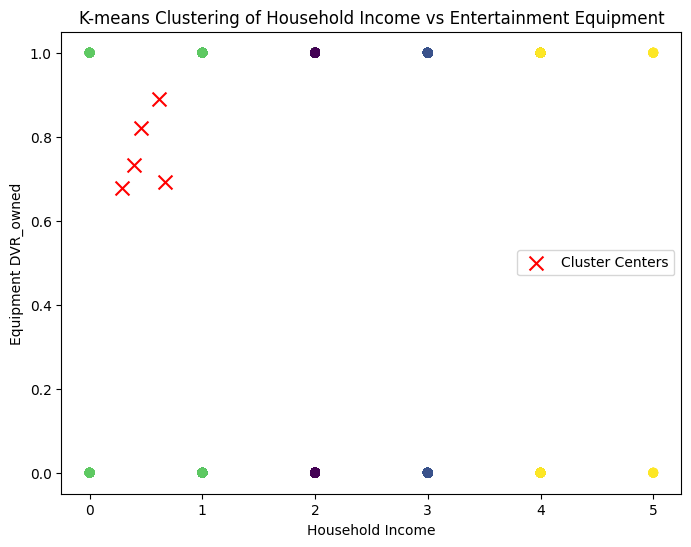

In [47]:
# Analyze clusters
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)  # Reverse scaling to interpret cluster centers

print("Cluster Centers:")
print(cluster_centers)

# Data distribution among clusters
print("Data Distribution in Clusters:")
print(income_equipment_data['Cluster'].value_counts())

# Visualize the clusters with 2 features
plt.figure(figsize=(8, 6))
plt.scatter(income_equipment_data['Income_Num'], income_equipment_data['DVR_owned'], c=cluster_labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='red', label='Cluster Centers')
plt.xlabel('Household Income')
plt.ylabel('Equipment DVR_owned')
plt.title('K-means Clustering of Household Income vs Entertainment Equipment')
plt.legend()
plt.show()

In [48]:
print(income_equipment_data.columns)


Index(['DVR_owned', 'FlatTV_owned', 'MediaBox_owned', 'Fob_owned', 'DVD_owned',
       'GamingCon_owned', 'PortableGame_owned', 'Router_owned',
       'Desktop_owned', 'Laptop_owned', 'LapTabHybrid_owned', 'Tab9in_owned',
       'Tab7_9in_owned', 'EbookReader_owned', 'Smartphone3_5in_owned',
       'LargeSmartphone_owned', 'BasicMobile_owned', 'Smartwatch_owned',
       'FitnessBand_owned', 'SmartGlasses_owned', '3DPrinter_owned',
       'None_owned', 'DontKnow_owned', 'Income_Num', 'Income_0', 'Income_1',
       'Income_2', 'Income_3', 'Income_4', 'Income_5', 'Cluster'],
      dtype='object')


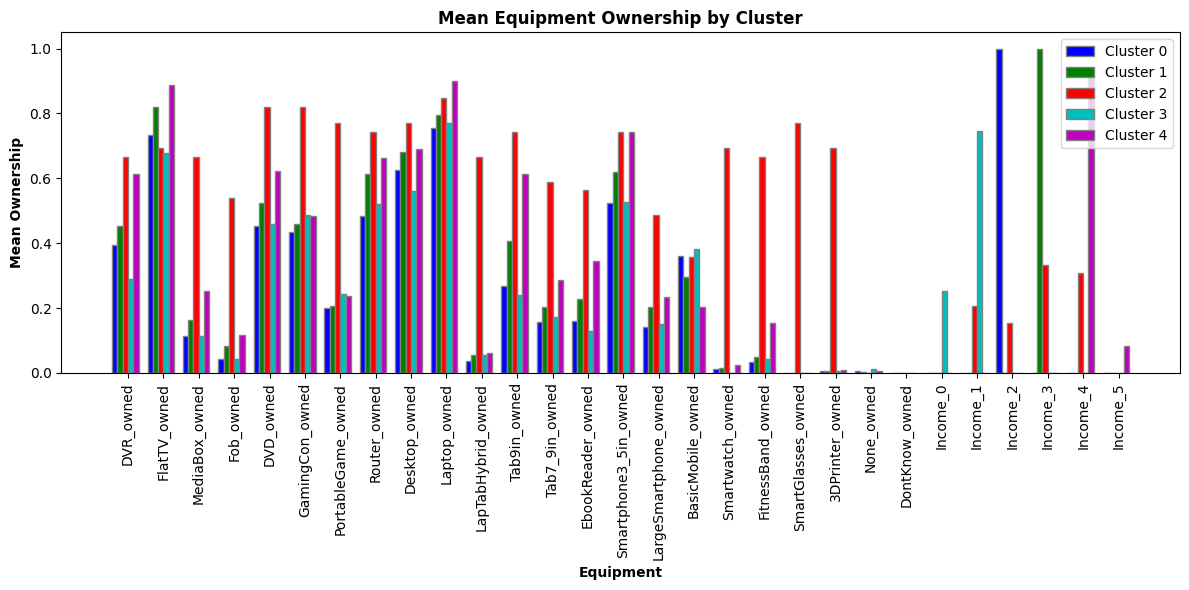

In [66]:
# A grouped bar chart showing the mean ownership of different equipment types across the clusters
# Mean ownership of equipment within each cluster
cluster_means = income_equipment_data.groupby('Cluster').mean().reset_index()


# Plotting - for some reason seaborn is failing 
equipment = cluster_means.drop(['Cluster', 'Income_Num'], axis=1).columns
cluster_0_means = cluster_means.drop(['Cluster', 'Income_Num'], axis=1).iloc[0].values
cluster_1_means = cluster_means.drop(['Cluster', 'Income_Num'], axis=1).iloc[1].values
cluster_2_means = cluster_means.drop(['Cluster', 'Income_Num'], axis=1).iloc[2].values
cluster_3_means = cluster_means.drop(['Cluster', 'Income_Num'], axis=1).iloc[3].values
cluster_4_means = cluster_means.drop(['Cluster', 'Income_Num'], axis=1).iloc[4].values

num_clusters = len(cluster_means)


bar_width = 0.15

r1 = np.arange(len(equipment))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

plt.figure(figsize=(12, 6))
plt.bar(r1, cluster_0_means, color='b', width=bar_width, edgecolor='grey', label='Cluster 0')
plt.bar(r2, cluster_1_means, color='g', width=bar_width, edgecolor='grey', label='Cluster 1')
plt.bar(r3, cluster_2_means, color='r', width=bar_width, edgecolor='grey', label='Cluster 2')
plt.bar(r4, cluster_3_means, color='c', width=bar_width, edgecolor='grey', label='Cluster 3')
plt.bar(r5, cluster_4_means, color='m', width=bar_width, edgecolor='grey', label='Cluster 4')

plt.xlabel('Equipment', fontweight='bold')
plt.ylabel('Mean Ownership', fontweight='bold')
plt.xticks([r + bar_width * (num_clusters / 2) for r in range(len(equipment))], equipment, rotation=90)
plt.title('Mean Equipment Ownership by Cluster', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()